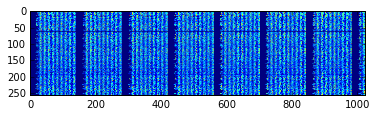

In [445]:
from __future__ import division
%matplotlib inline

import cvxpy as cvx
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

X = 0;

for k in np.arange(0,100):
    X = X + 1.0 * img.imread('%s%d%s' % ('ambient/frame_',k,'.tif'));

plt.imshow(X)

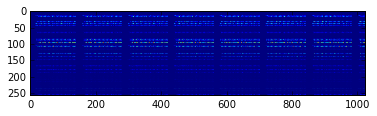

In [183]:
Y = 0;

for k in np.arange(0,100):
    Y = Y + 1.0 * img.imread('%s%d%s' % ('dark/frame_',k,'.tif'));

plt.imshow(Y)

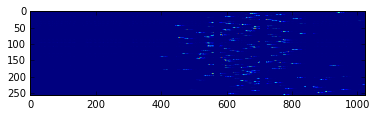

In [219]:
Z = 0;

for k in np.arange(0,100):
    Z = Z + 1.0 * img.imread('%s%d%s' % ('laser_0cm/frame_',k,'.tif'));

plt.imshow(Z)

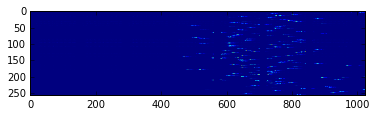

In [285]:
Z15 = 0;

for k in np.arange(0,100):
    Z15 = Z15 + 1.0 * img.imread('%s%d%s' % ('laser_15cm/frame_',k,'.tif'));

plt.imshow(Z15)

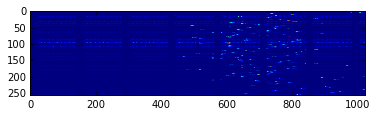

In [416]:
Zlow = 0;

for k in np.arange(0,100):
    Zlow = Zlow + 1.0 * img.imread('%s%d%s' % ('laser_0cm_lowintensity/frame_',k,'.tif'));

plt.imshow(Zlow)

In [458]:

photons = np.sum(X,axis=1);
photons_per_bin = photons / X.shape[1];
print photons/100

[  5.56850310e+05   5.61025390e+05   5.74074070e+05   5.67627260e+05
   5.69915430e+05   5.53152960e+05   5.40318280e+05   5.37125390e+05
   5.52621190e+05   5.38088940e+05   5.59541630e+05   5.49737750e+05
   5.63576120e+05   5.50397510e+05   5.44849920e+05   5.49619130e+05
   5.36716480e+05   5.20065150e+05   5.65343440e+05   4.87866150e+05
   5.39587300e+05   5.39026190e+05   5.57023250e+05   5.30862370e+05
   5.15263900e+05   5.00617620e+05   4.82457080e+05   5.19343010e+05
   4.96326590e+05   5.01342780e+05   5.01662930e+05   4.95413700e+05
   5.16873920e+05   5.32726540e+05   4.49416390e+05   5.15884930e+05
   5.06895390e+05   5.02854510e+05   5.30565100e+05   5.25960720e+05
   5.39320310e+05   5.15323700e+05   4.89354850e+05   5.31573330e+05
   5.29126700e+05   4.68914950e+05   5.25945230e+05   5.14795800e+05
   4.84490490e+05   5.12332710e+05   5.15882820e+05   5.30485140e+05
   5.12882050e+05   4.86241670e+05   5.10176900e+05   5.16641690e+05
   4.04770540e+05   4.89094800e+05

In [221]:
print(Y.shape)

(256, 1024)


In [222]:
# For optimization, keep original histograms.
# Determine which time interval each bin corresponds to by finding bin size
# and also time shift of SPAD.

# NOTE: ambient light and dark count should be modeled separately from intensity field,
# as causing firings uniformly distributed in time (not in raw histograms!)

In [418]:
# Map onto evenly spaced histogram buckets.
def repack(uniform, samples, num_times):
    
    normalized = uniform/uniform.sum(axis=1)[:,None]
    normalized[np.isnan(normalized)] = 0
    
    normalized = (normalized * num_times).cumsum(axis=1)
    even_time = np.zeros((normalized.shape[0], num_times))
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            tmp = min( int(np.floor(normalized[i,j])), 255)
            even_time[i, tmp] += samples[i, j]
            
            
    return even_time

In [309]:
# Shift pixels so max is at chosen center.
def recenter(samples, center):
    maxes = np.argmax(samples, axis=1)
    shift = maxes - center
    return shift_hist(samples, shift), shift
    
def shift_hist(samples, shift):
    result = np.zeros(samples.shape)
    for i in range(samples.shape[0]):
        for j in range(samples.shape[1]):
            new_j = j + shift[i]
            if 0 <= new_j < samples.shape[1]:
                result[i,j] = samples[i, j + shift[i]]
    return result

(256,)
(256, 256)


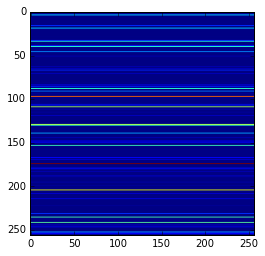

In [250]:
# Dark count should not be time dependent.
fixed_pattern = Y.sum(axis=1)/256
print(fixed_pattern).shape
fixed_pattern = np.tile(fixed_pattern, (256, 1)).T
print(fixed_pattern).shape
plt.imshow(fixed_pattern)

/Users/stevend2/anaconda/envs/cvxpy/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


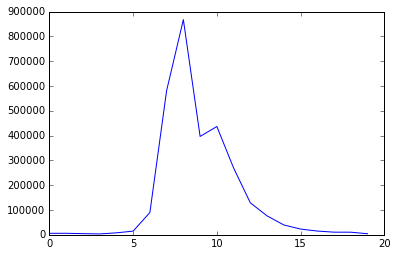

In [424]:
T = 28
Wtmp = repack(X, Z, 256)
W, shift = recenter(Wtmp, 128)
# plt.plot(W[T+1,:])
# plt.show()
# even_time2 = repack(Y, Z, 256)
# plt.plot(even_time2[T,:])
# plt.imshow(W)

/Users/stevend2/anaconda/envs/cvxpy/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


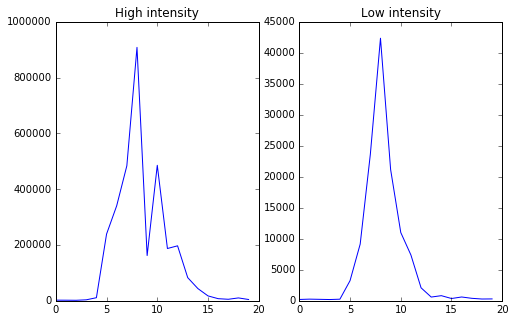

In [435]:
T = 28
Wtmplow = repack(X, Zlow, 256)
Wlow, shift = recenter(Wtmplow, 128)
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(W[2,120:140])
plt.title('High intensity')
plt.subplot(1,2,2)
plt.plot(Wlow[2,120:140])
plt.title('Low intensity')
# plt.plot(W[T+1,:])
plt.show()
# even_time2 = repack(Y, Z, 256)
# plt.plot(even_time2[T,:])
# plt.imshow(Wlow)

/Users/stevend2/anaconda/envs/cvxpy/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


[   0.            0.            0.         ...,  255.30763702  255.36034439
  256.        ]


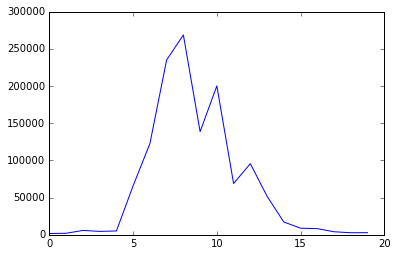

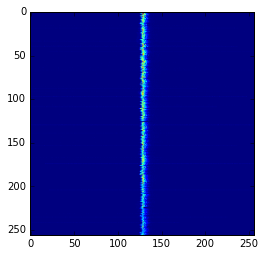

In [415]:
T = 28
W15, _ = shift_hist(repack(X, Z15, 256), shift)
# even_time2 = repack(Y, Z, 256)
plt.plot(W15[T,135:155])
plt.show()
plt.imshow(W)

In [409]:
tmp = (shift - shift15)*(3e8/60e6)/233
np.median(tmp)

-0.30042918454935624

In [278]:
# Total number of events.
FRAMES = 100
# FREQ = 1/100e-9
FREQ = 60e6
EVENTS_PER_FRAME = (1/60) * FREQ / 4
EVENTS = FRAMES*EVENTS_PER_FRAME
tmp = W.sum(axis=1)/EVENTS
tmp.argmax()

174

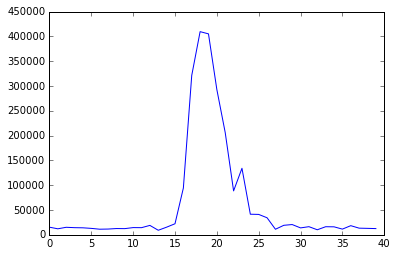

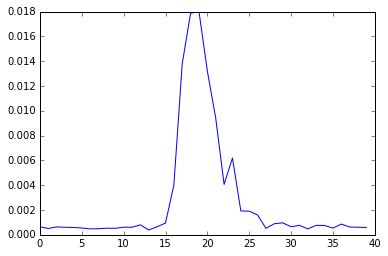

In [284]:
def coates(N, h):
    T = h.size
    r = np.zeros(T)
    r[0] = -np.log(1-h[0]/N)
    for k in range(1,T):
        tmp = N - np.sum(h[:k])
        r[k] = -np.log(1-h[k]/tmp)
    return r

correct = coates(EVENTS, W[174,:])
plt.plot(W[174, 110:150])
plt.show()
plt.plot(correct[110:150])

/Users/stevend2/anaconda/envs/cvxpy/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


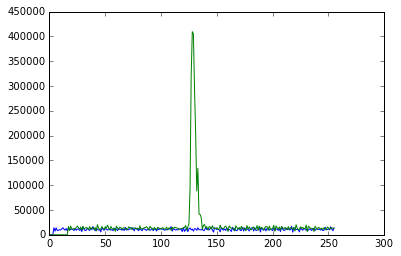

optimal


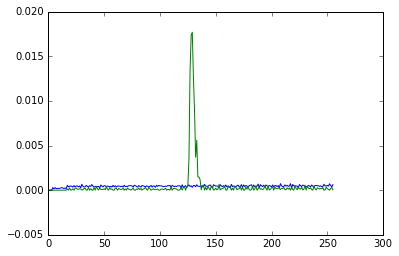

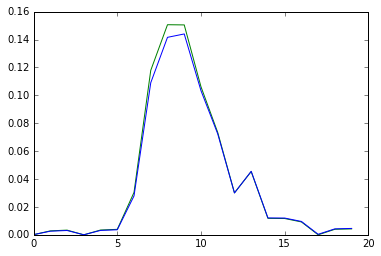

In [441]:
T = 174
N = EVENTS
r = cvx.Variable(256)
d = cvx.Variable(256)
Ytmp, _ = shift_hist(repack(X, Y, 256), shift)
dc = Ytmp[T,:]
h = W[T,:]
plt.plot(dc)
plt.plot(h)
plt.show()

scale = (dc.sum() + h.sum())/2
l = r + d
LL = cvx.log(1 - cvx.exp(-d)).T*dc - cvx.cumsum(d)[:-1].T*dc[1:] -(N - dc.sum())*cvx.sum_entries(d)
LL += cvx.log(1 - cvx.exp(-l)).T*h - cvx.cumsum(l)[:-1].T*h[1:] -(N - h.sum())*cvx.sum_entries(l)

prob = cvx.Problem(cvx.Maximize(LL/scale), [r >= 0])
prob.solve(solver=cvx.ECOS, max_iters=500)#, abstol=1e-10, reltol=1e-10, feastol=1e-10)
print(prob.status)
plt.plot(d.value)
plt.plot(r.value)
plt.show()
tmp = np.maximum(W[T,:] - Ytmp[T,:], 0)
plt.plot((tmp/tmp.sum())[120:140], color='green')
plt.plot( (r.value.A1/r.value.sum())[120:140])

In [400]:
bucket_size = 1/(60e6*NUM_BUCKETS)
c = 3e8
FWHM_laser = 60e-12
sigma_laser = FWHM_laser/(2*np.sqrt(2*np.log(2)))
sigma_laser /= bucket_size
inv_sig = cvx.Parameter(value=1/sigma_laser)

optimal
5.38661342892
126.060945929
23.4026346223
2.63725828303


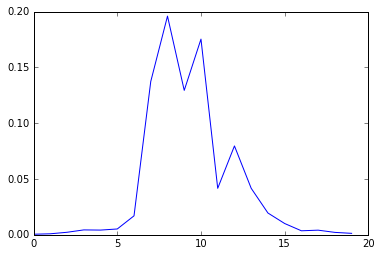

In [437]:
tmp = np.maximum(W[T,:] - Ytmp[T,:], 0)
hist = tmp/tmp.sum()
plt.plot(hist[120:140])
# Now fit a Gaussian.
inv_sig = cvx.Variable()
mu_sig = cvx.Variable()
x = np.arange(256)
ll = np.sum(hist)*cvx.log(inv_sig) - hist.T*(x*inv_sig - mu_sig)**2/2
prob = cvx.Problem(cvx.Maximize(ll))
prob.solve(solver=cvx.CVXOPT, verbose=False, max_iters=100)
print(prob.status)
estimate = (mu_sig.value/inv_sig.value)
print estimate
print 1/inv_sig.value
print estimate*bucket_size*c

optimal
135.493775215
36.5903703918
2.83459780785


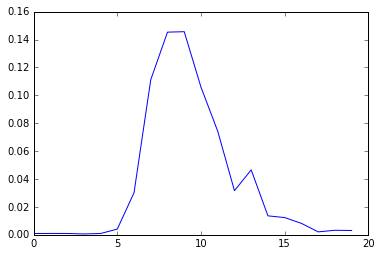

In [411]:
hist = r.value.A1/r.value.sum()
plt.plot(hist[120:140])
# Now fit a Gaussian.

inv_sig = cvx.Variable()
mu_sig = cvx.Variable()
x = np.arange(256)
ll = np.sum(hist)*cvx.log(inv_sig) - hist.T*(x*inv_sig - mu_sig)**2/2
prob = cvx.Problem(cvx.Maximize(ll))
prob.solve(solver=cvx.CVXOPT, verbose=False, max_iters=100)
print(prob.status)
estimate = (mu_sig.value/inv_sig.value)
print estimate
print 1/inv_sig.value
print estimate*bucket_size*c